I've come up with a cleaner way to solve for $u_\star$ and $z_\star$. Recall the wind profile $u(z)$ is given by
$$
u(z) = \frac{u_\star}{\kappa} \ln \left( \frac{z}{z_\star} \right).
$$

We can solve for the difference in wind speeds between levels in a way that does not depend on $z_\star$:
$$
\Delta u = u(z) - u(z_0) = \frac{u_\star}{\kappa} \ln \left( \frac{z}{z_\star} \right) - \frac{u_\star}{\kappa} \ln \left( \frac{z_0}{z_\star} \right) = \frac{u_\star}{\kappa} \ln \left( \frac{z}{z_0} \right).
$$

And
$$
\sigma_{\Delta u} = \sqrt{\sigma_{u(z)}^2 + \sigma_{u(z_0)}^2}.
$$

These equations allow us to solve directly for $u_\star$ and its uncertainties without needing $z_\star$. Then we can parlay those solutions into an equation relating the knowns to the unknowns. Defining the scaled velocities as
$$
u^\prime(z) = \frac{\kappa u(z)}{u_\star} = \ln \left( \frac{z}{z_0} \right) - \ln \left( \frac{z_\star}{z_0} \right).
$$

With
$$
\sigma_{u^\prime} = u^\prime \sqrt{\left( \frac{\sigma_{u_\star}}{\sigma_{u_\star}} \right)^2 + \left( \frac{\sigma_{u}}{\sigma_u} \right)^2}.
$$

In [55]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt

from local_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# WS_file = '/Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/WE__0133___________DER_WS__________________P01.xml'
which_sol = "0107"
path = '/Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/'
WS_file = path + 'WE__%s___________DER_WS__________________P02.xml' % (which_sol)

time, wind = retrieve_time_wind(WS_file, start_time=datetime(1900, 1, 1, 9, 0, 0), end_time=datetime(1900, 1, 1, 10, 0, 0))
wind *= 100. # Convert to cm/s

Processing label: /Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/WE__0107___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE


Text(0, 0.5, '$U\\ \\left( {\\rm m\\ s^{-1}} \\right)$')

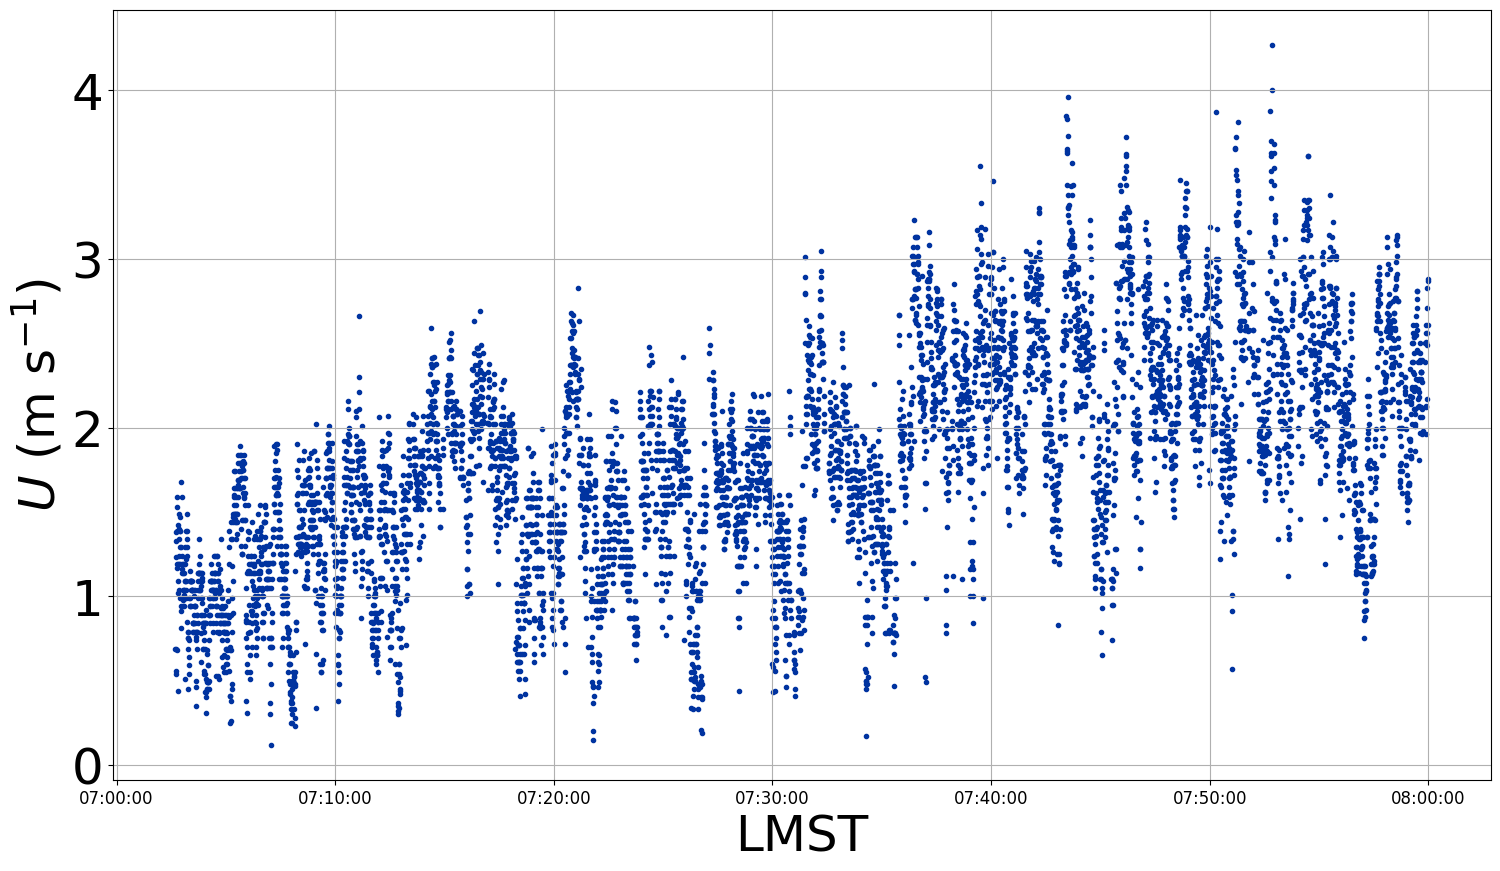

In [22]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

ax.scatter(time, wind, marker='.', color=BoiseState_blue)

xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.grid(True)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=36)
ax.set_xlabel("LMST", fontsize=36)
ax.set_ylabel(r'$U\ \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
# ax.set_xlim([start_time, end_time])

27.3004529502534
[15.17930037] [9.15011296]
3.0
[0.07246521] [0.0359558]


/var/folders/qn/shk5dvhn3mb9twv7bvyjp5nm0000gn/T/ipykernel_1849/772007061.py:24: RuntimeWarning: invalid value encountered in log
  log_z_star = np.log(z_star/z[0])


(-25566.623137847222, -25566.62128599537)

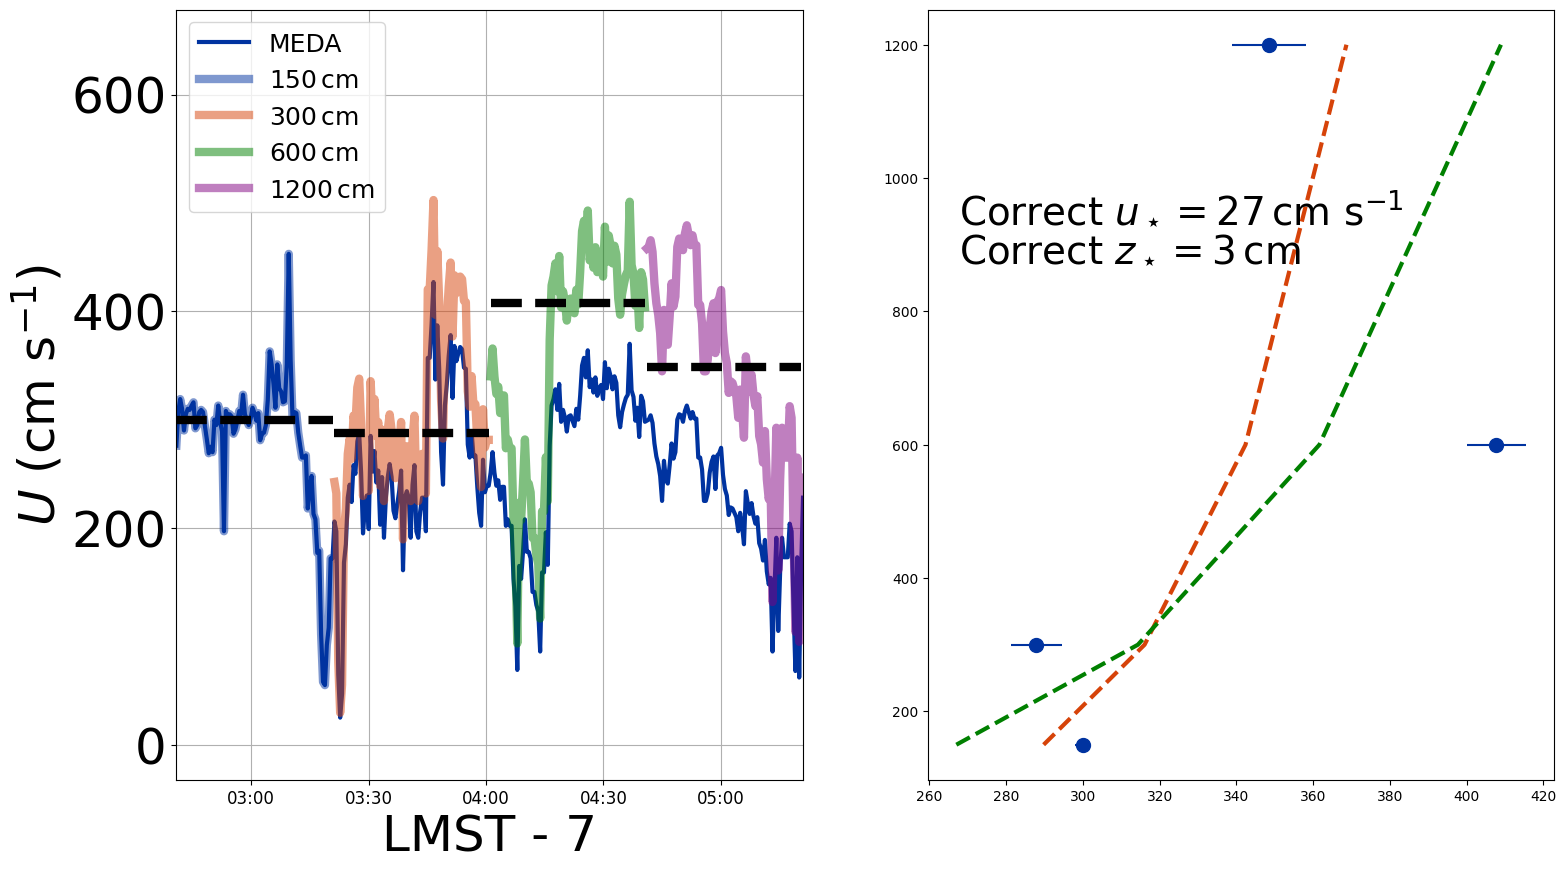

In [58]:
def calc_delta_u(u):
    # Assumes u is sorted in ascending order
    return u[1:] - u[0]

def calc_sigma_delta_u(sigma_u):
    # Assumes u is sorted in ascending order
    return np.sqrt(sigma_u[1:]**2 + sigma_u[0]**2)

def calc_u_prime(u, u_star):
    return kappa*u/u_star

def calc_sigma_scaled_u(u_prime, u_star, u, sigma_u_star, sigma_u):
    return u_prime*np.sqrt((sigma_u_star/u_star)**2 + (sigma_u/u)**2)

def fit_delta_u(z, u_star):
    # Assumes z is sorted in ascending order
    log_z = np.log(z[1:]/z[0])
    
    return u_star/kappa*log_z

def fit_log_zstar(z, z_star):
    # Assumes z is sorted in ascending order
    log_z = np.log(z/z[0])
    log_z_star = np.log(z_star/z[0])
    
    return log_z - log_z_star

fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

saved_zstar = 3. # cm
t0 = np.min(time)
ind = retrieve_relevant_times(time, t0, len(zs)*sample_time)
saved_ustar = kappa*np.median(wind[ind])/np.log(zs[0]/saved_zstar)

scaled_windspeeds = create_synthetic_wind_profile(wind, zs, saved_zstar, z0=np.min(zs))
t0 = np.min(time)
averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_time, t0, time, scaled_windspeeds, zs)
ax1 = make_plot_of_original_and_scaled_windspeeds(time, wind, zs, sample_time, t0, scaled_windspeeds, 
                                                  averaged_windspeeds, ax1)

# Fit u_star
delta_u = calc_delta_u(averaged_windspeeds)
sigma_delta_u = calc_sigma_delta_u(std_windspeeds)
u_star, sigma_u_star_sq = curve_fit(fit_delta_u, zs, delta_u, sigma=sigma_delta_u)
sigma_u_star = np.sqrt(sigma_u_star_sq)[0]
print(saved_ustar)
print(u_star, sigma_u_star)

# Fit z_star
u_prime = calc_scaled_u(averaged_windspeeds, u_star)
sigma_u_prime = calc_sigma_scaled_u(u_prime, u_star, averaged_windspeeds, sigma_u_star, std_windspeeds)
z_star, sigma_z_star_sq = curve_fit(fit_log_zstar, zs, u_prime, sigma=sigma_u_prime)
sigma_z_star = np.sqrt(sigma_z_star_sq)[0]
print(saved_zstar)
print(z_star, sigma_z_star)

ax2.errorbar(averaged_windspeeds, zs, xerr=std_windspeeds, marker='o', markersize=10, color=BoiseState_blue, ls='')
ax2.plot(wind_profile(zs, u_star, z_star), zs, lw=3, ls='--', color=BoiseState_orange)
ax2.plot(wind_profile(zs, saved_ustar, saved_zstar), zs, lw=3, ls='--', color='green')

ax2.text(0.05, 0.725, r'Correct $u_\star = %.0f\, {\rm cm\ s^{-1}}$' % (saved_ustar), 
         fontsize=28, transform=ax2.transAxes)
ax2.text(0.05, 0.675, r'Correct $z_\star = %.0f\, {\rm cm}$' % (saved_zstar), 
         fontsize=28, transform=ax2.transAxes)

ax1.set_xlim([np.min(time), np.min(time) + timedelta(seconds=len(zs)*sampling_duration)])
# fig.savefig("Synthetic_Mars_Wind_Profile_Sol133.jpg", dpi=300, bbox_inches="tight")

60.98814590109452 18.448627814933438
62.578075002763995 19.728846191593345


(-25566.61805521991, -25566.615971886575)

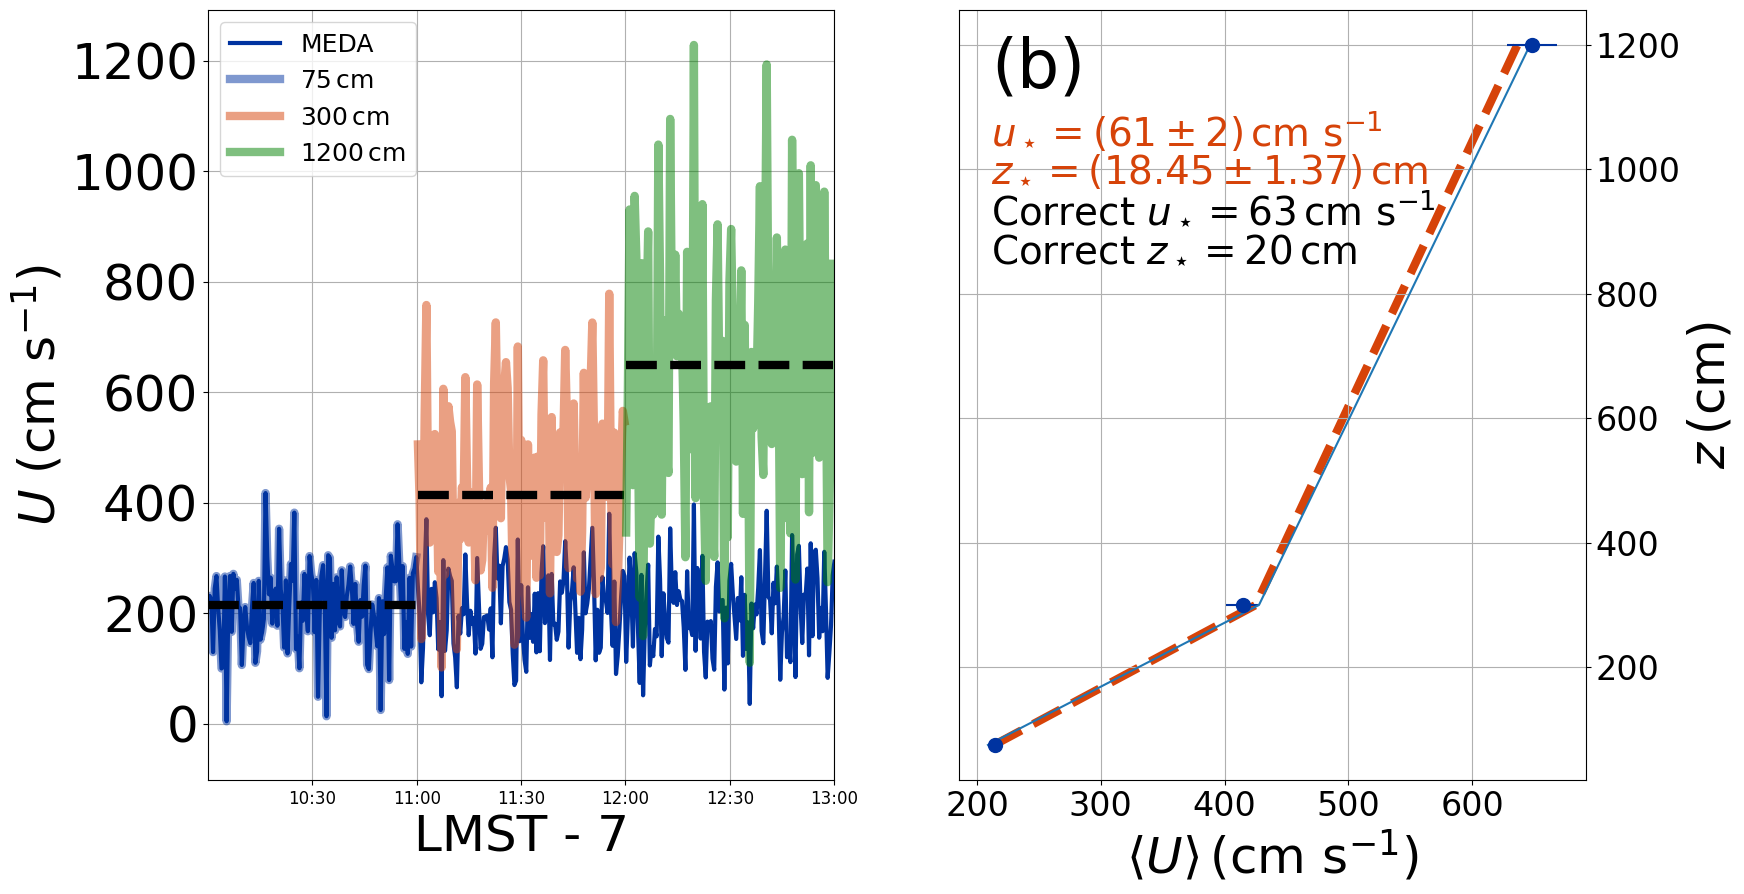

In [159]:
# Completely synthetic dataset
med = np.median(wind)
md = mad(wind)
synthetic_wind = med + normal(size=len(wind), scale=md)

fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

saved_zstar = 20. # cm
t0 = np.min(time)
ind = retrieve_relevant_times(time, t0, len(zs)*sample_time)
saved_ustar = kappa*np.median(synthetic_wind[ind])/np.log(zs[0]/saved_zstar)

scaled_windspeeds = create_synthetic_wind_profile(synthetic_wind, zs, saved_zstar, z0=np.min(zs))
t0 = np.min(time)
averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_time, t0, time, scaled_windspeeds, zs)
ax1 = make_plot_of_original_and_scaled_windspeeds(time, synthetic_wind, zs, sample_time, t0, scaled_windspeeds, 
                                                  averaged_windspeeds, ax1)

### Fit synthetic wind profile ###

# Take the three points with the smallest scatter
# srt_ind = np.argsort(std_windspeeds)
# cur_zs = zs[srt_ind[:3]]
# cur_averaged_windspeeds = averaged_windspeeds[srt_ind[:3]]
# cur_std_windspeeds = std_windspeeds[srt_ind[:3]]
# srt_ind = np.argsort(cur_zs)
# cur_zs = cur_zs[srt_ind]
# cur_averaged_windspeeds = cur_averaged_windspeeds[srt_ind]
# cur_std_windspeeds = cur_std_windspeeds[srt_ind]

# inlier_zs, inlier_averaged_windspeeds, inlier_std_windspeeds,\
#     outlier_zs, outlier_averaged_windspeeds, outlier_std_windspeeds,\
#     popt, unc, pcov = fit_wind_profile_and_drop_outliers(cur_zs, cur_averaged_windspeeds, cur_std_windspeeds,
#                                                          drop_outliers=False, num_sigma=5., rescale_unc=False,
#                                                          consider_scaled_uncertainties=False)

inlier_zs, inlier_averaged_windspeeds, inlier_std_windspeeds,\
    outlier_zs, outlier_averaged_windspeeds, outlier_std_windspeeds,\
    popt, unc, pcov = fit_wind_profile_and_drop_outliers(zs, averaged_windspeeds, std_windspeeds,
                                                         drop_outliers=True, num_sigma=5., rescale_unc=True,
                                                         consider_scaled_uncertainties=True)

ustar, zstar, sigma_ustar, sigma_zstar = collect_fit_values_and_unc(popt, unc, pcov)
print(ustar, zstar)
simple_ustar = kappa*np.mean((averaged_windspeeds[1:] - averaged_windspeeds[:-1])/np.log(zs[1:]/zs[:-1]))
simple_zstar = np.mean(zs/np.exp(kappa*averaged_windspeeds/simple_ustar))
print(simple_ustar, simple_zstar)
ax2 = make_plot_of_wind_data_and_profile(inlier_zs, inlier_averaged_windspeeds, inlier_std_windspeeds,
                                         outlier_zs, outlier_averaged_windspeeds, outlier_std_windspeeds, 
                                         popt, unc, pcov, ax2)

ax2.plot(wind_profile(zs, saved_ustar, saved_zstar), zs)

ax2.text(0.05, 0.725, r'Correct $u_\star = %.0f\, {\rm cm\ s^{-1}}$' % (saved_ustar), 
         fontsize=28, transform=ax2.transAxes)
ax2.text(0.05, 0.675, r'Correct $z_\star = %.0f\, {\rm cm}$' % (saved_zstar), 
         fontsize=28, transform=ax2.transAxes)

ax1.set_xlim([np.min(time), np.min(time) + timedelta(seconds=len(zs)*sampling_duration)])
# fig.savefig("Synthetic_Mars_Wind_Profile_Sol133.jpg", dpi=300, bbox_inches="tight")